# VGG Network

Here we use multiple 3x3 convolutions in series inside a block. Then we do a MaxPool to reduce the width in half.

In [1]:
device = "cuda"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
!pip install -q duckduckgo_search
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 115 (delta 61), reused 33 (delta 15), pack-reused 0
Receiving objects: 100% (115/115), 4.45 MiB | 12.01 MiB/s, done.
Resolving deltas: 100% (61/61), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.0a0+293.g0930f712e6 requires pandas<1.4.0dev0,>=1.0, but you have pandas 1.4.2 which is incompatible.


In [4]:
transform_pil=transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Resize(224),
    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [5]:
ds_train = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)
ds_valid = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)

In [6]:
ds_train[0][0].shape

torch.Size([1, 224, 224])

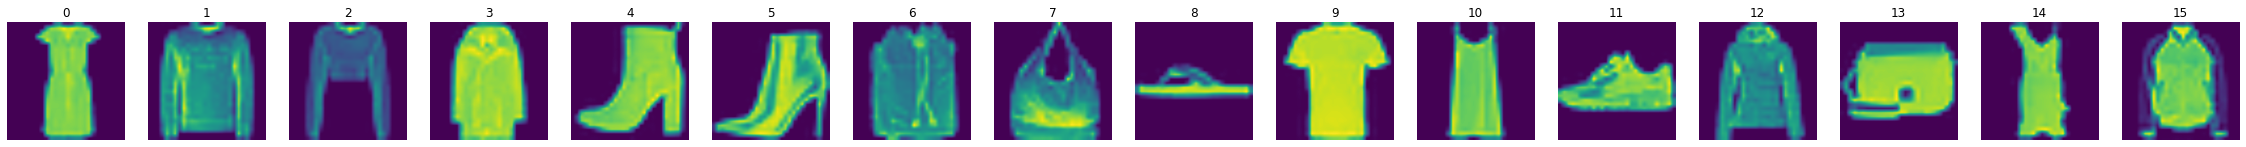

In [10]:
_dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=16)
sample_batch = next(iter(_dl))
test_images = sample_batch[0].to(device)
I.wrap(test_images).show(cols=16)

## VGG Block

In [16]:
def make_vgg_block(n_conv_layers, n_dims):
    layers = []
    for i in range(n_conv_layers):
        layers.append(nn.LazyConv2d(n_dims, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    
    return nn.Sequential(*layers)

In [21]:
sample_vgg_block = make_vgg_block(2, 10).to(device)
sample_vgg_block

Sequential(
  (0): LazyConv2d(0, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): LazyConv2d(0, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [24]:
test_images.shape

torch.Size([16, 1, 224, 224])

In [25]:
sample_vgg_block(test_images).shape

torch.Size([16, 10, 112, 112])

**See. It halves the size output**

## VGG11

Here we create a set of VGG blocks, resulting 11 layers (8conv + 3linear)

In [29]:
class VGG11(nn.Module):
    def __init__(self):
        super().__init__()
        
        # (1, 64), (1, 128), (2, 256), (2, 512), (2, 512)
        self.net = nn.Sequential(
            make_vgg_block(1, 64),
            make_vgg_block(1, 128),
            make_vgg_block(2, 256),
            make_vgg_block(2, 512),
            make_vgg_block(2, 512),
            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(10)
        )
        
    def forward(self, images):
        return self.net(images)
    
_m = VGG11().to(device)
_m(test_images).shape

torch.Size([16, 10])

## Let's Train It

In [55]:
# testing initialization
model = VGG11().to(device)
model(test_images)
def init_weights(layer):
    if type(layer) == nn.modules.conv.Conv2d or type(layer) == nn.modules.linear.Linear:
        print(layer)
        nn.init.xavier_uniform_(layer.weight)
model.apply(init_weights)
None

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear(in_features=25088, out_features=4096, bias=True)
Linear(in_features=4096, out_features=4096, bias=True)
Linear(in_features=4096, out_features=10, bias=True)


In [56]:
def calc_accuracy(images, labels):
    batch_size = len(images)
    pred = model(images)
    pred = pred.detach()

    pred_labels = torch.argmax(pred, dim=-1)
    accuracy = (pred_labels == labels).sum() / batch_size * 100

    return accuracy

In [57]:
def train(epochs=1):
    loss_list = []
    valid_loss_list = []
    accuracy_list = []
    valid_accuracy_list = []

    lp = I.live_plot(2)
    i = 0

    for epoch in range(epochs):
        for batch in tqdm(dl_train):
            i += 1;
            images = batch[0].to(device)
            labels = batch[1].to(device)
            batch_size = len(images)

            optimizer.zero_grad()

            yhat = model(images)
            loss = F.cross_entropy(yhat, labels)

            loss.backward()

            with torch.no_grad():   
                optimizer.step()


        with torch.no_grad():
            _dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            train_images, train_lables = sample[0].to(device), sample[1].to(device)

            accuracy_list.append(calc_accuracy(train_images, train_lables).cpu().item())
            train_loss = F.cross_entropy(model(train_images), train_lables)
            loss_list.append(train_loss.item())

            _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            valid_images, valid_lables = sample[0].to(device), sample[1].to(device)

            valid_accuracy_list.append(calc_accuracy(valid_images, valid_lables).cpu().item())
            valid_loss = F.cross_entropy(model(valid_images), valid_lables)
            valid_loss_list.append(valid_loss.item())

        lp.plot(0, loss_list, label="train loss")
        lp.plot(0, valid_loss_list, label="valid loss")
        lp.plot(1, accuracy_list, label="train accuracy")
        lp.plot(1, valid_accuracy_list, label="valid accuracy")
        lp.update()

    lp.close()

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


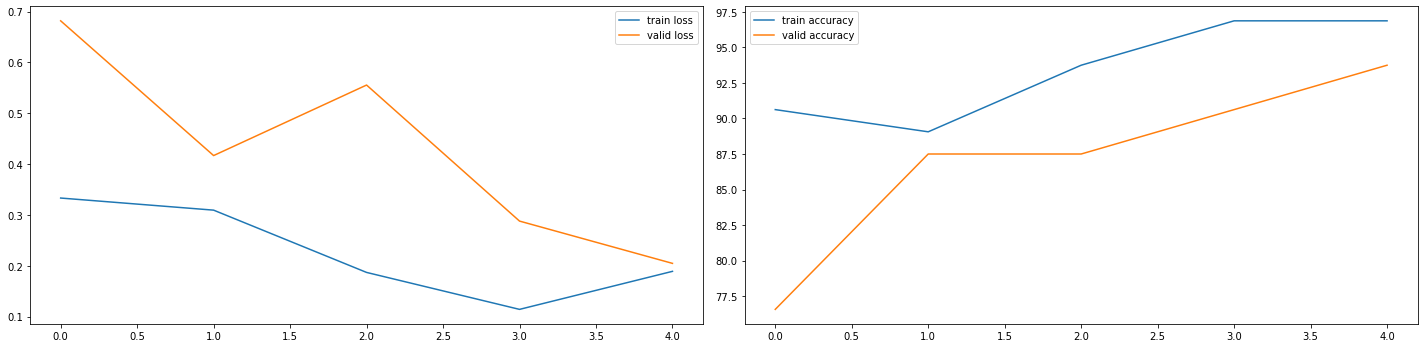

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [58]:
bs = 32
lr = 0.01
wd = 0.0005

def init_weights(layer):
    if type(layer) == nn.modules.conv.Conv2d or type(layer) == nn.modules.linear.Linear:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = VGG11().to(device)
model(test_images) #need to initialize parameters for the lazy
model.apply(init_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [59]:
def calc_valid_accuracy():
    _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=128)
    accuracy_list = []
    for batch in tqdm(_dl):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            accuracy_list.append(calc_accuracy(images, labels))

    return torch.tensor(accuracy_list).mean().item()

calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

91.92874908447266

**Yep. It gives some slightly better accuracy than AlexNet.**

But it's bit better in terms of memory requirments.

Unfortunately, it takes a bit of time to run it.